<a href="https://colab.research.google.com/github/jrmazure/ece5831-2024-project/blob/main/notebooks/train-yolo11-object-detection-on-custom-dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook is run on Colab to avoid issues with GPU training on Windows

--From Roboflow (left this note for future troubleshooting): Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [8]:
!nvidia-smi

Tue Nov  5 02:09:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Import OS and get the current working directory

In [9]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOV11 with ultralytics

In [10]:
%pip install ultralytics supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.9/235.7 GB disk)


## Inference with model pre-trained on COCO dataset

Import libraries and use the yolo11n.pt as the main model to transfer learning from

In [11]:
from IPython.display import Image as IPyImage
from ultralytics import YOLO
from PIL import Image
import requests
import supervision as sv

model = YOLO('yolo11n.pt')

## Fine-tune YOLO11 on custom dataset

Create the datasets folder and move to that directory, then use roboflow to download the image dataset with training and testing folders

In [12]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow
from google.colab import userdata
from roboflow import Roboflow

rf = Roboflow(api_key="")
project = rf.workspace("screws-nvbc9").project("stopsignfinder")
version = project.version(2)
dataset = version.download("yolov11")


mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets
loading Roboflow workspace...
loading Roboflow project...


## Custom Training

Train the model. Task=detect is for a detection model, and model=yolo11s.pt uses transfer learning, we point towards the dataset location just created and labels .yaml, we also used 50 epochs and the real size of the image (512x512)

In [13]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=50 imgsz=512 plots=True

/content
Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/datasets/StopSignFinder-2/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True

Training results are saved in `{HOME}/runs/detect/train/`

In [14]:
!ls {HOME}/runs/detect/train/

args.yaml					    P_curve.png		 train_batch1.jpg
confusion_matrix_normalized.png			    PR_curve.png	 train_batch200.jpg
confusion_matrix.png				    R_curve.png		 train_batch201.jpg
events.out.tfevents.1730763450.10d284963a01.2194.0  results.csv		 train_batch202.jpg
F1_curve.png					    results.png		 train_batch2.jpg
labels_correlogram.jpg				    roboflow_deploy.zip  val_batch0_labels.jpg
labels.jpg					    state_dict.pt	 val_batch0_pred.jpg
model_artifacts.json				    train_batch0.jpg	 weights


Let's look at the confusion matrix

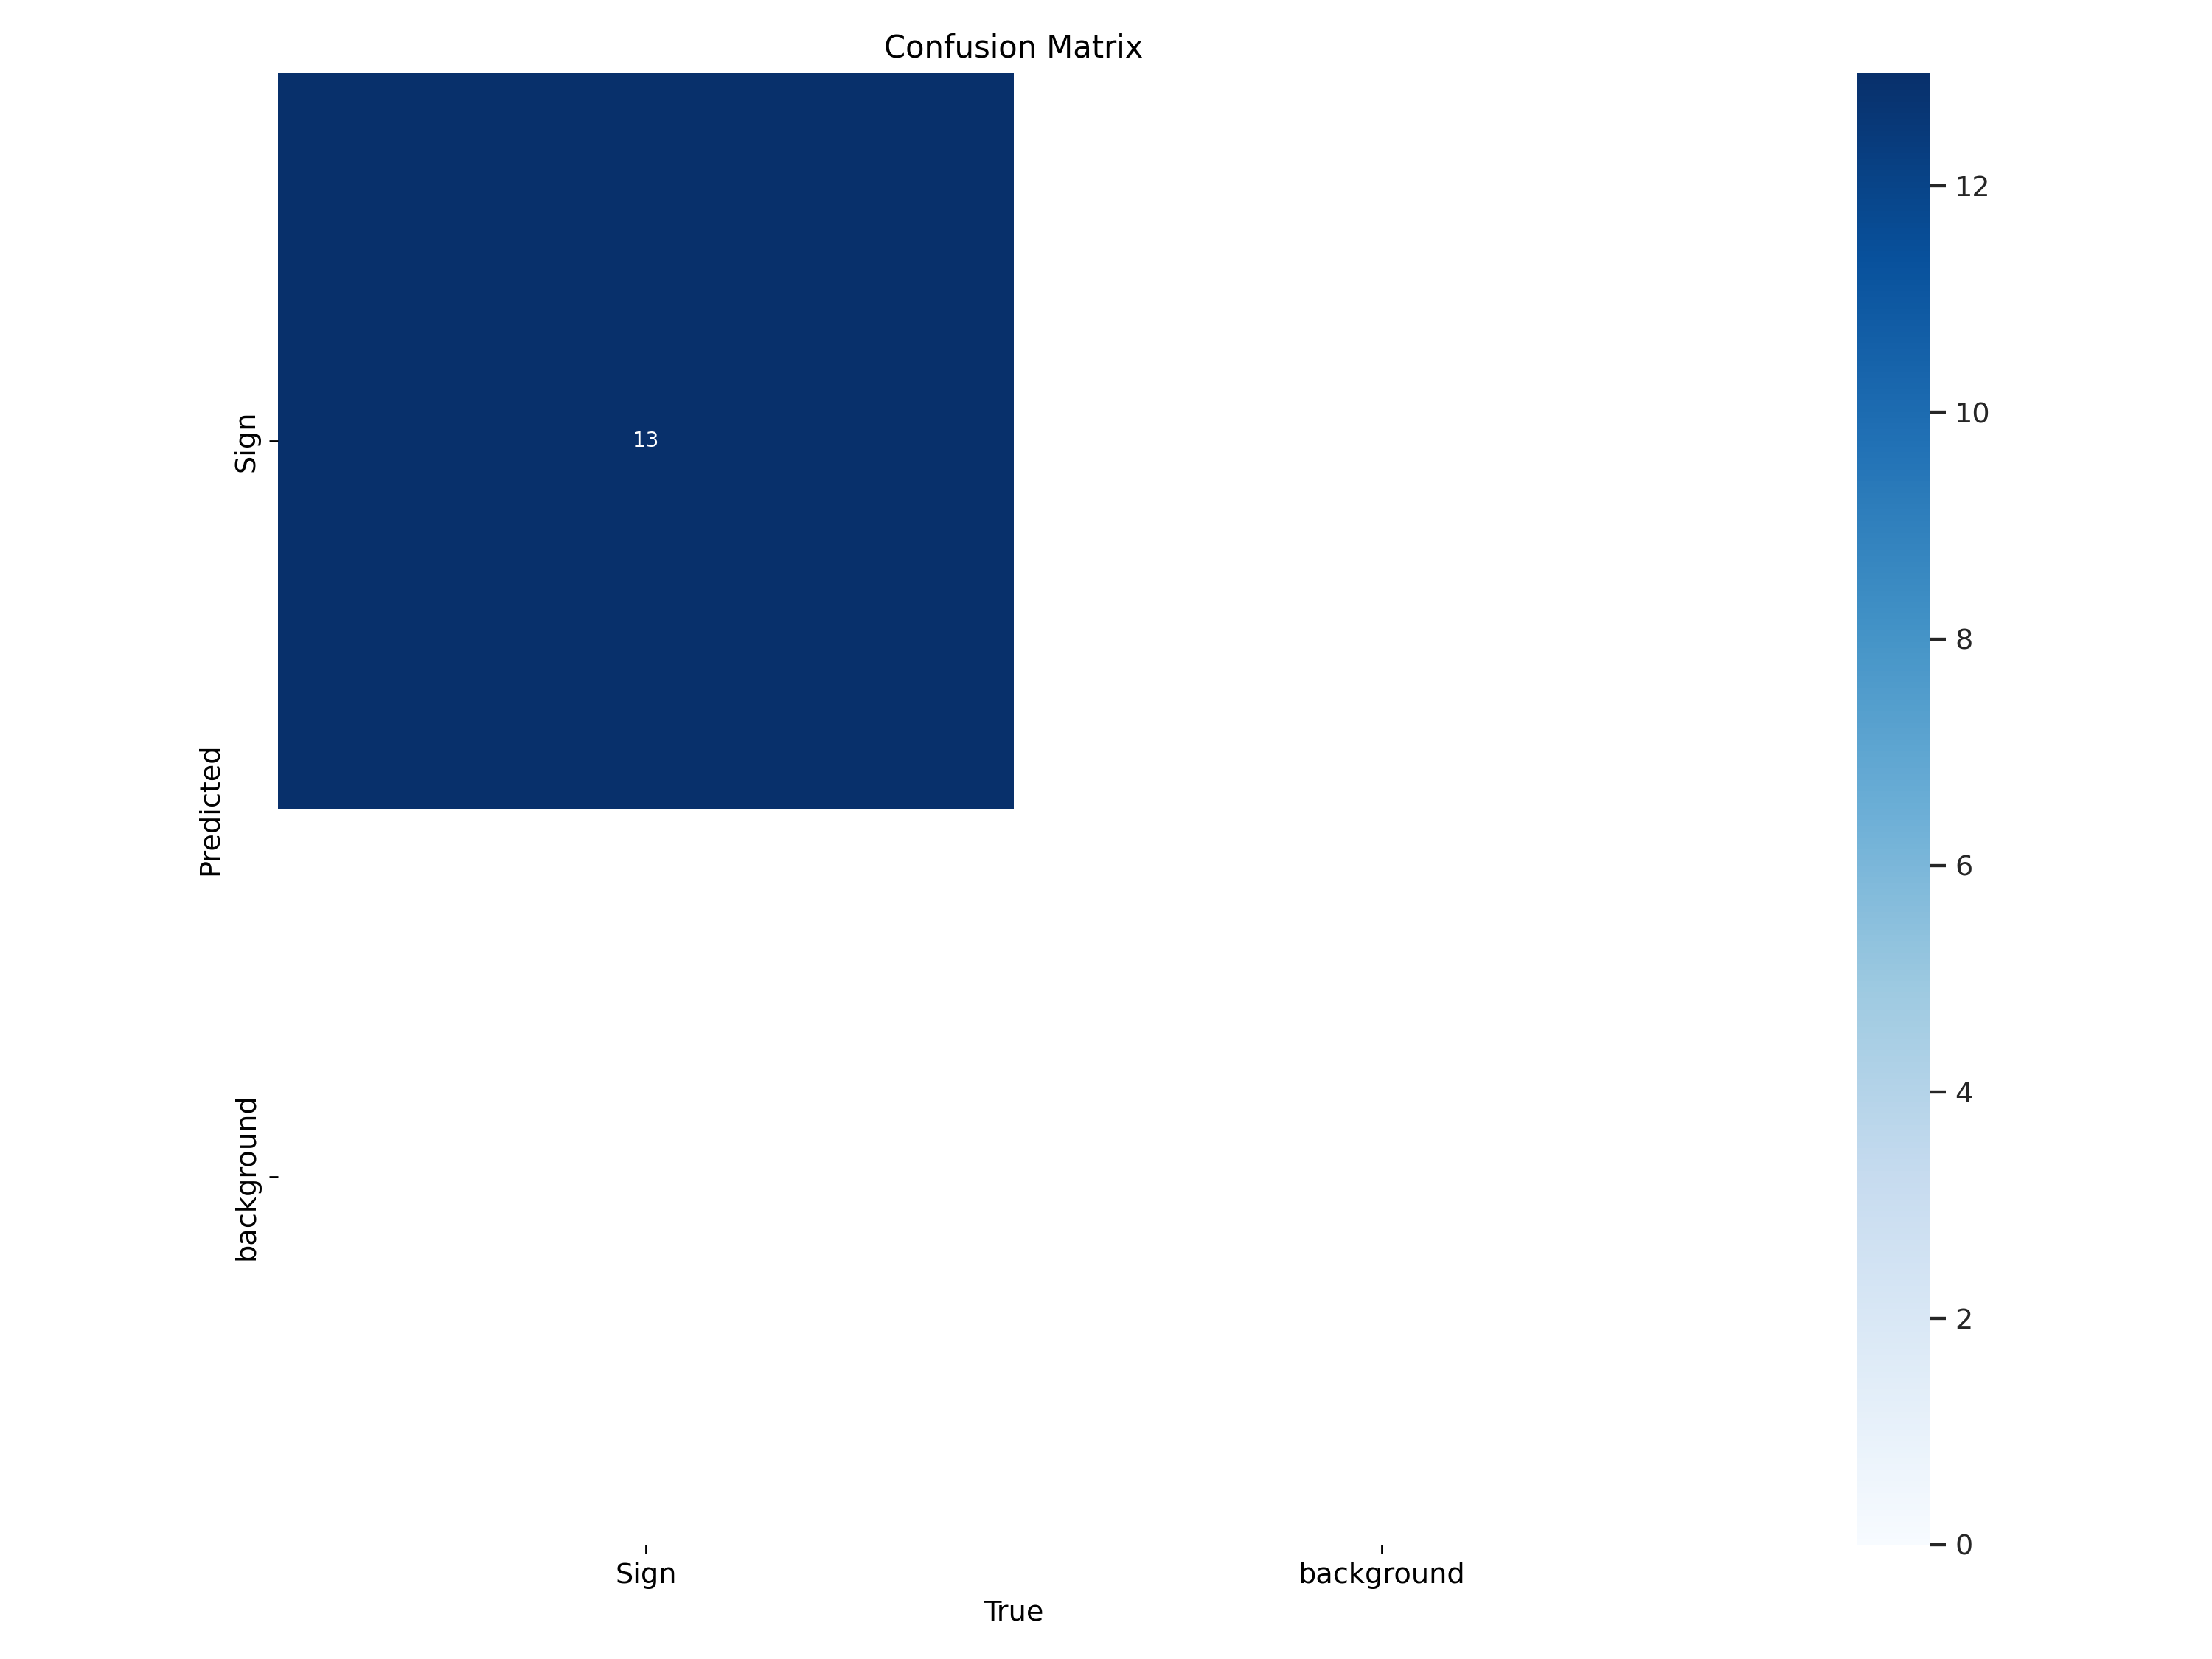

In [15]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

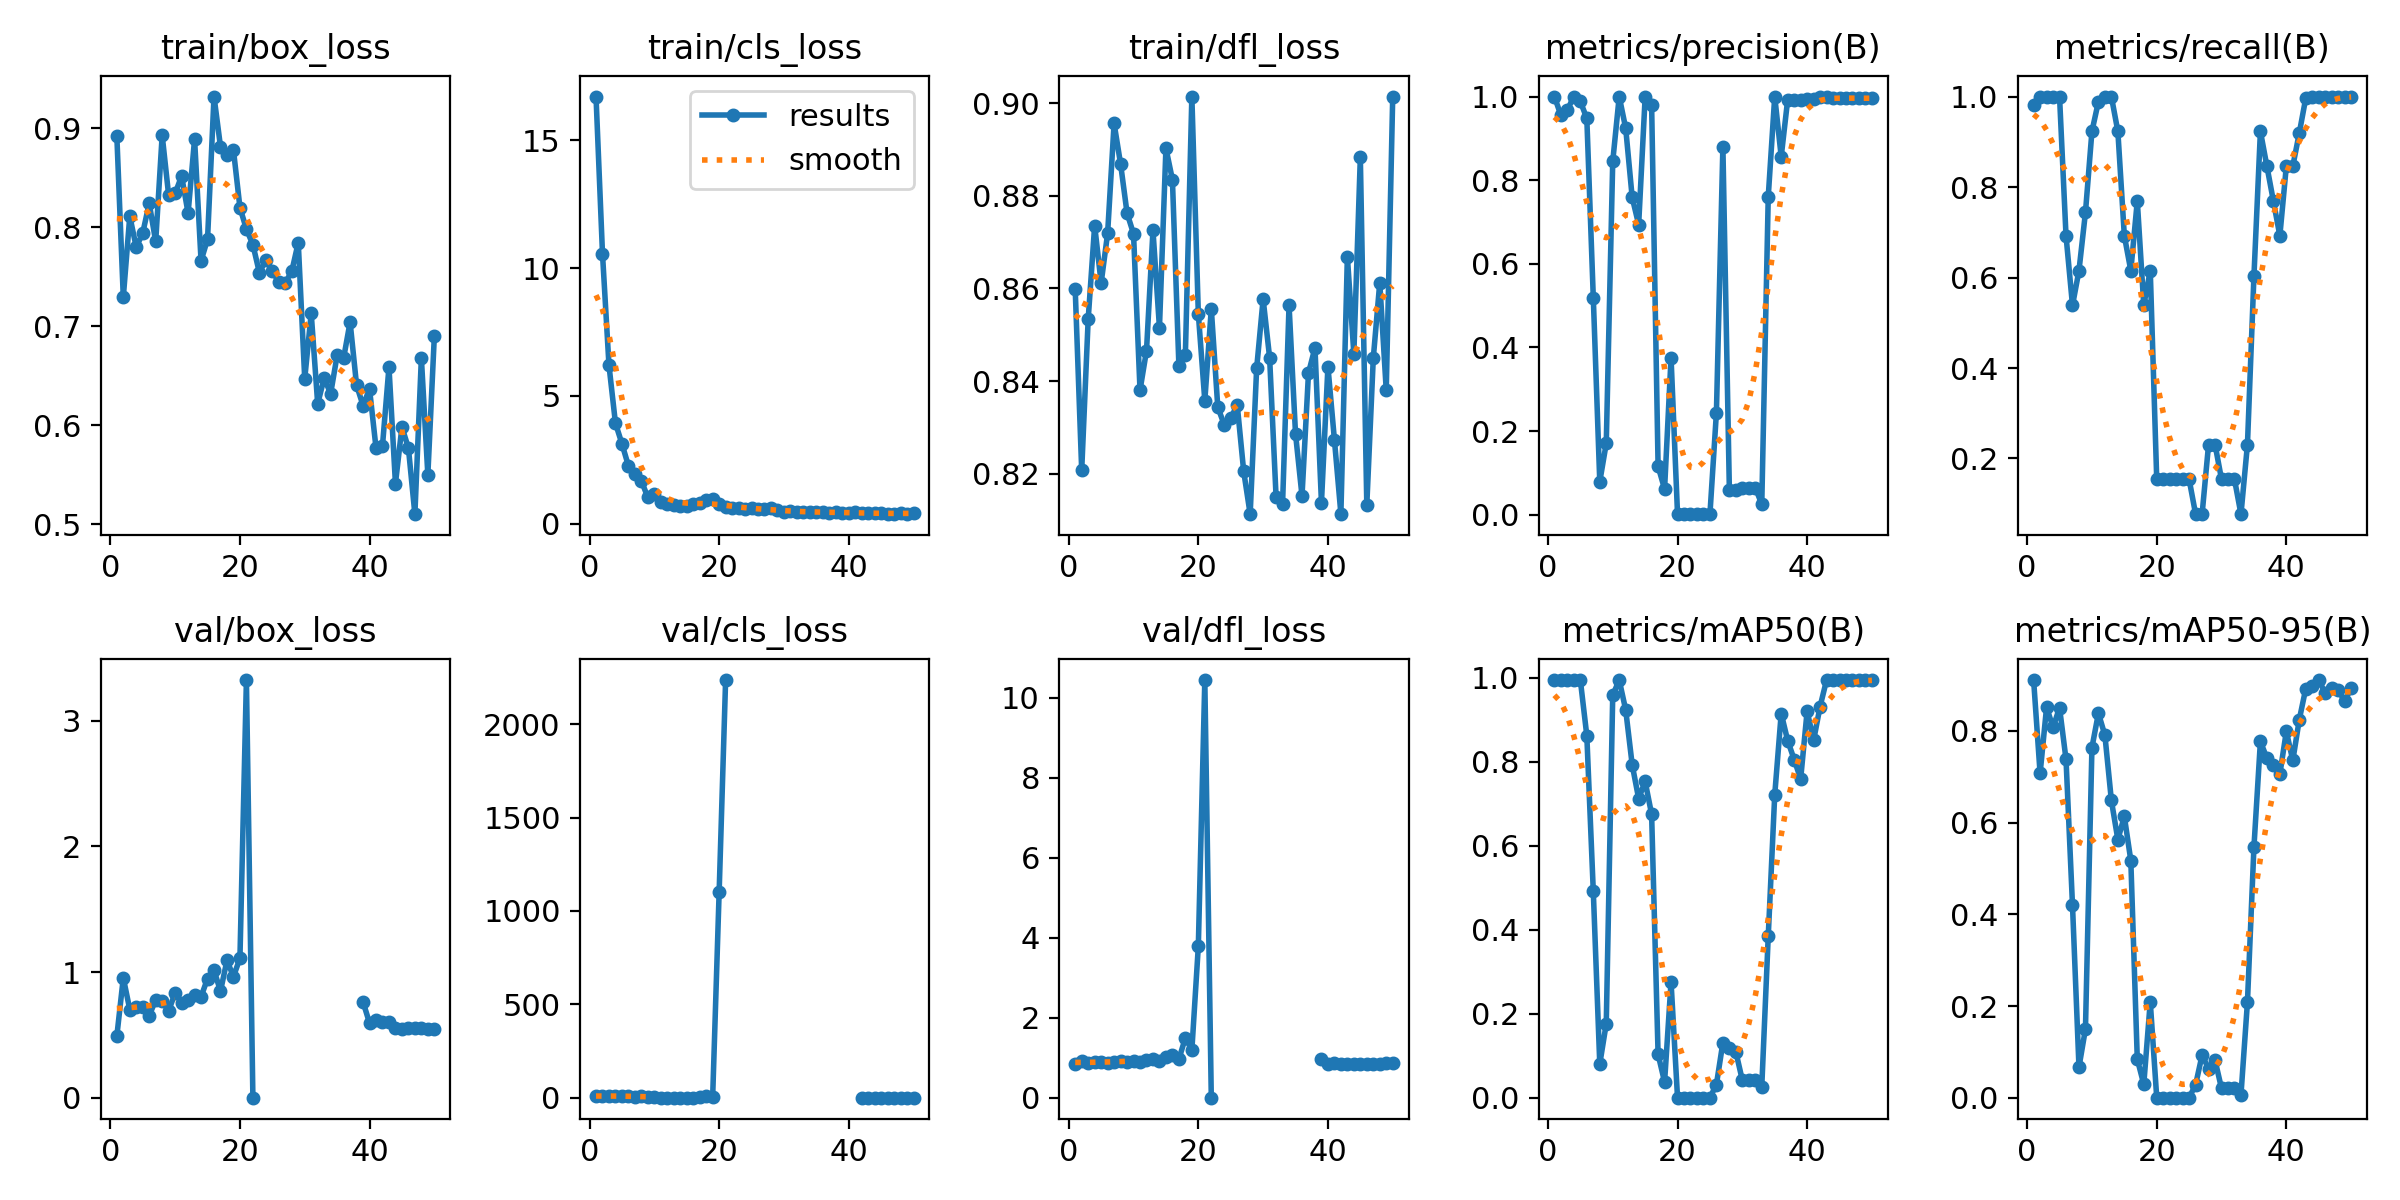

In [16]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

View a training batch to see the model output

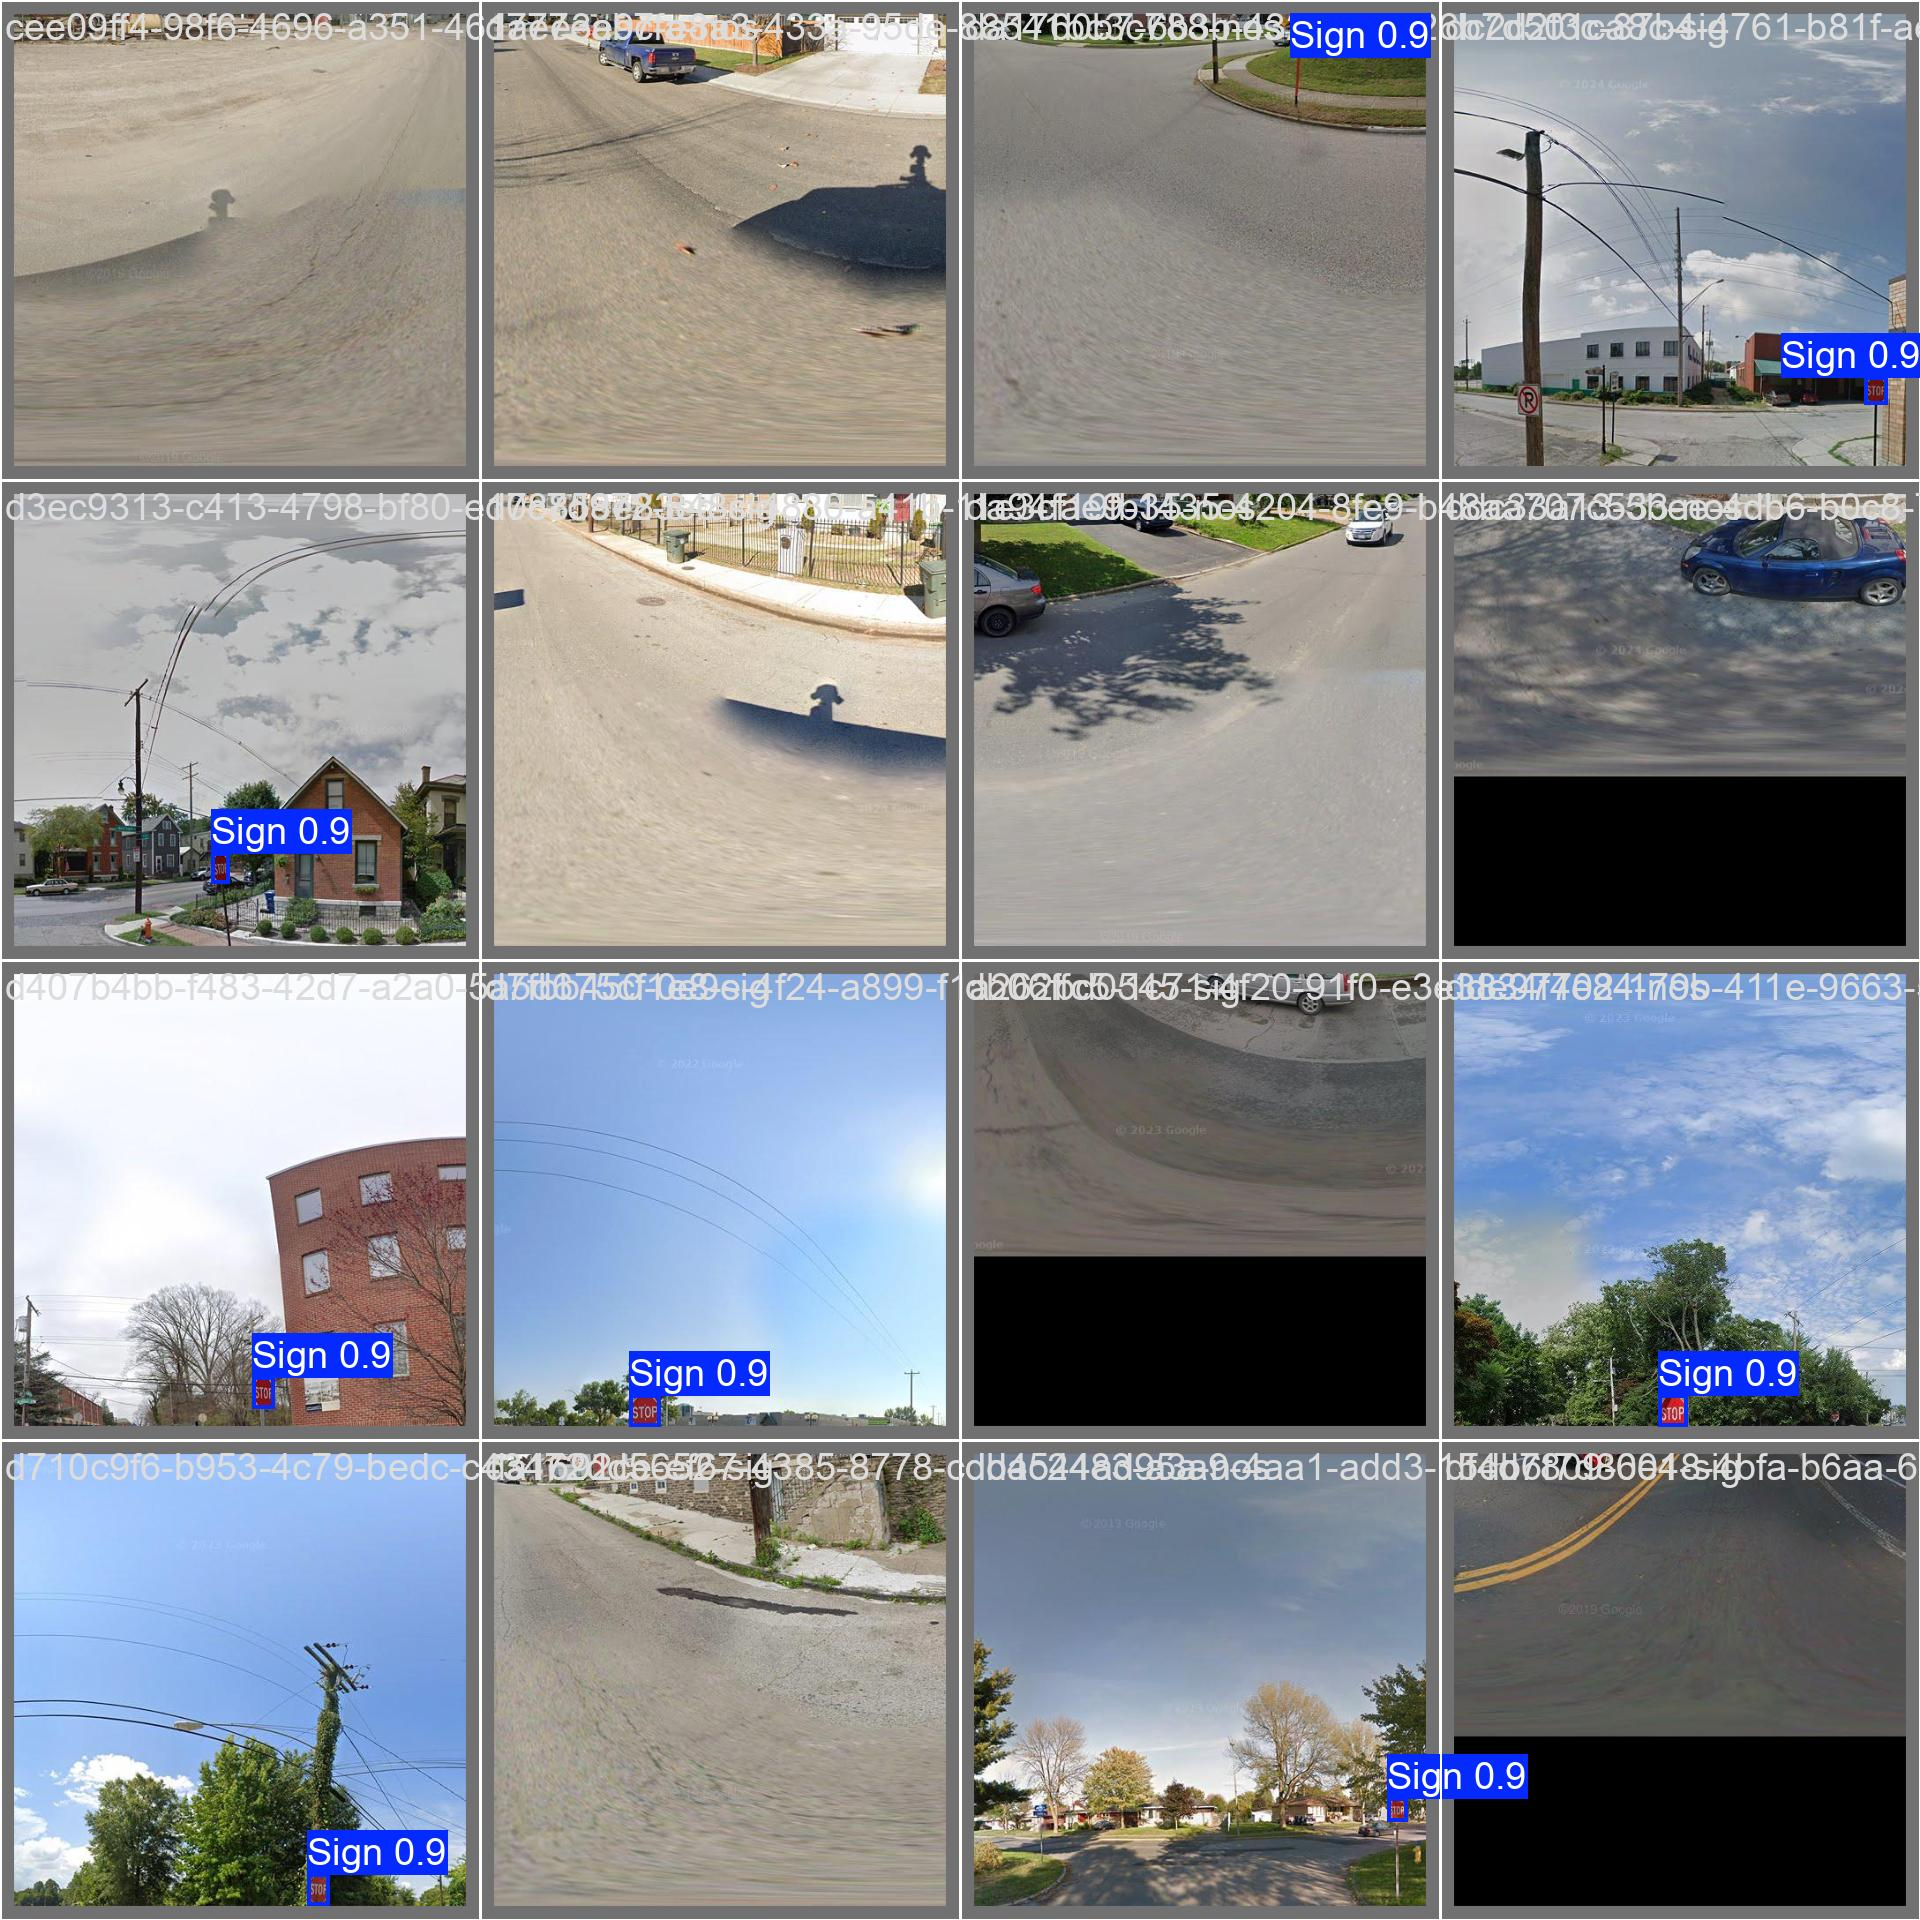

In [17]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Model Validation

In [18]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/datasets/StopSignFinder-2/valid/labels.cache... 24 images, 11 backgrounds, 0 corrupt: 100% 24/24 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 2/2 [00:02<00:00,  1.24s/it]
                   all         24         13      0.996          1      0.995      0.896
Speed: 5.5ms preprocess, 33.9ms inference, 0.0ms loss, 47.0ms postprocess per image
Results saved to runs/detect/val3
💡 Learn more at https://docs.ultralytics.com/modes/val


Display validation images

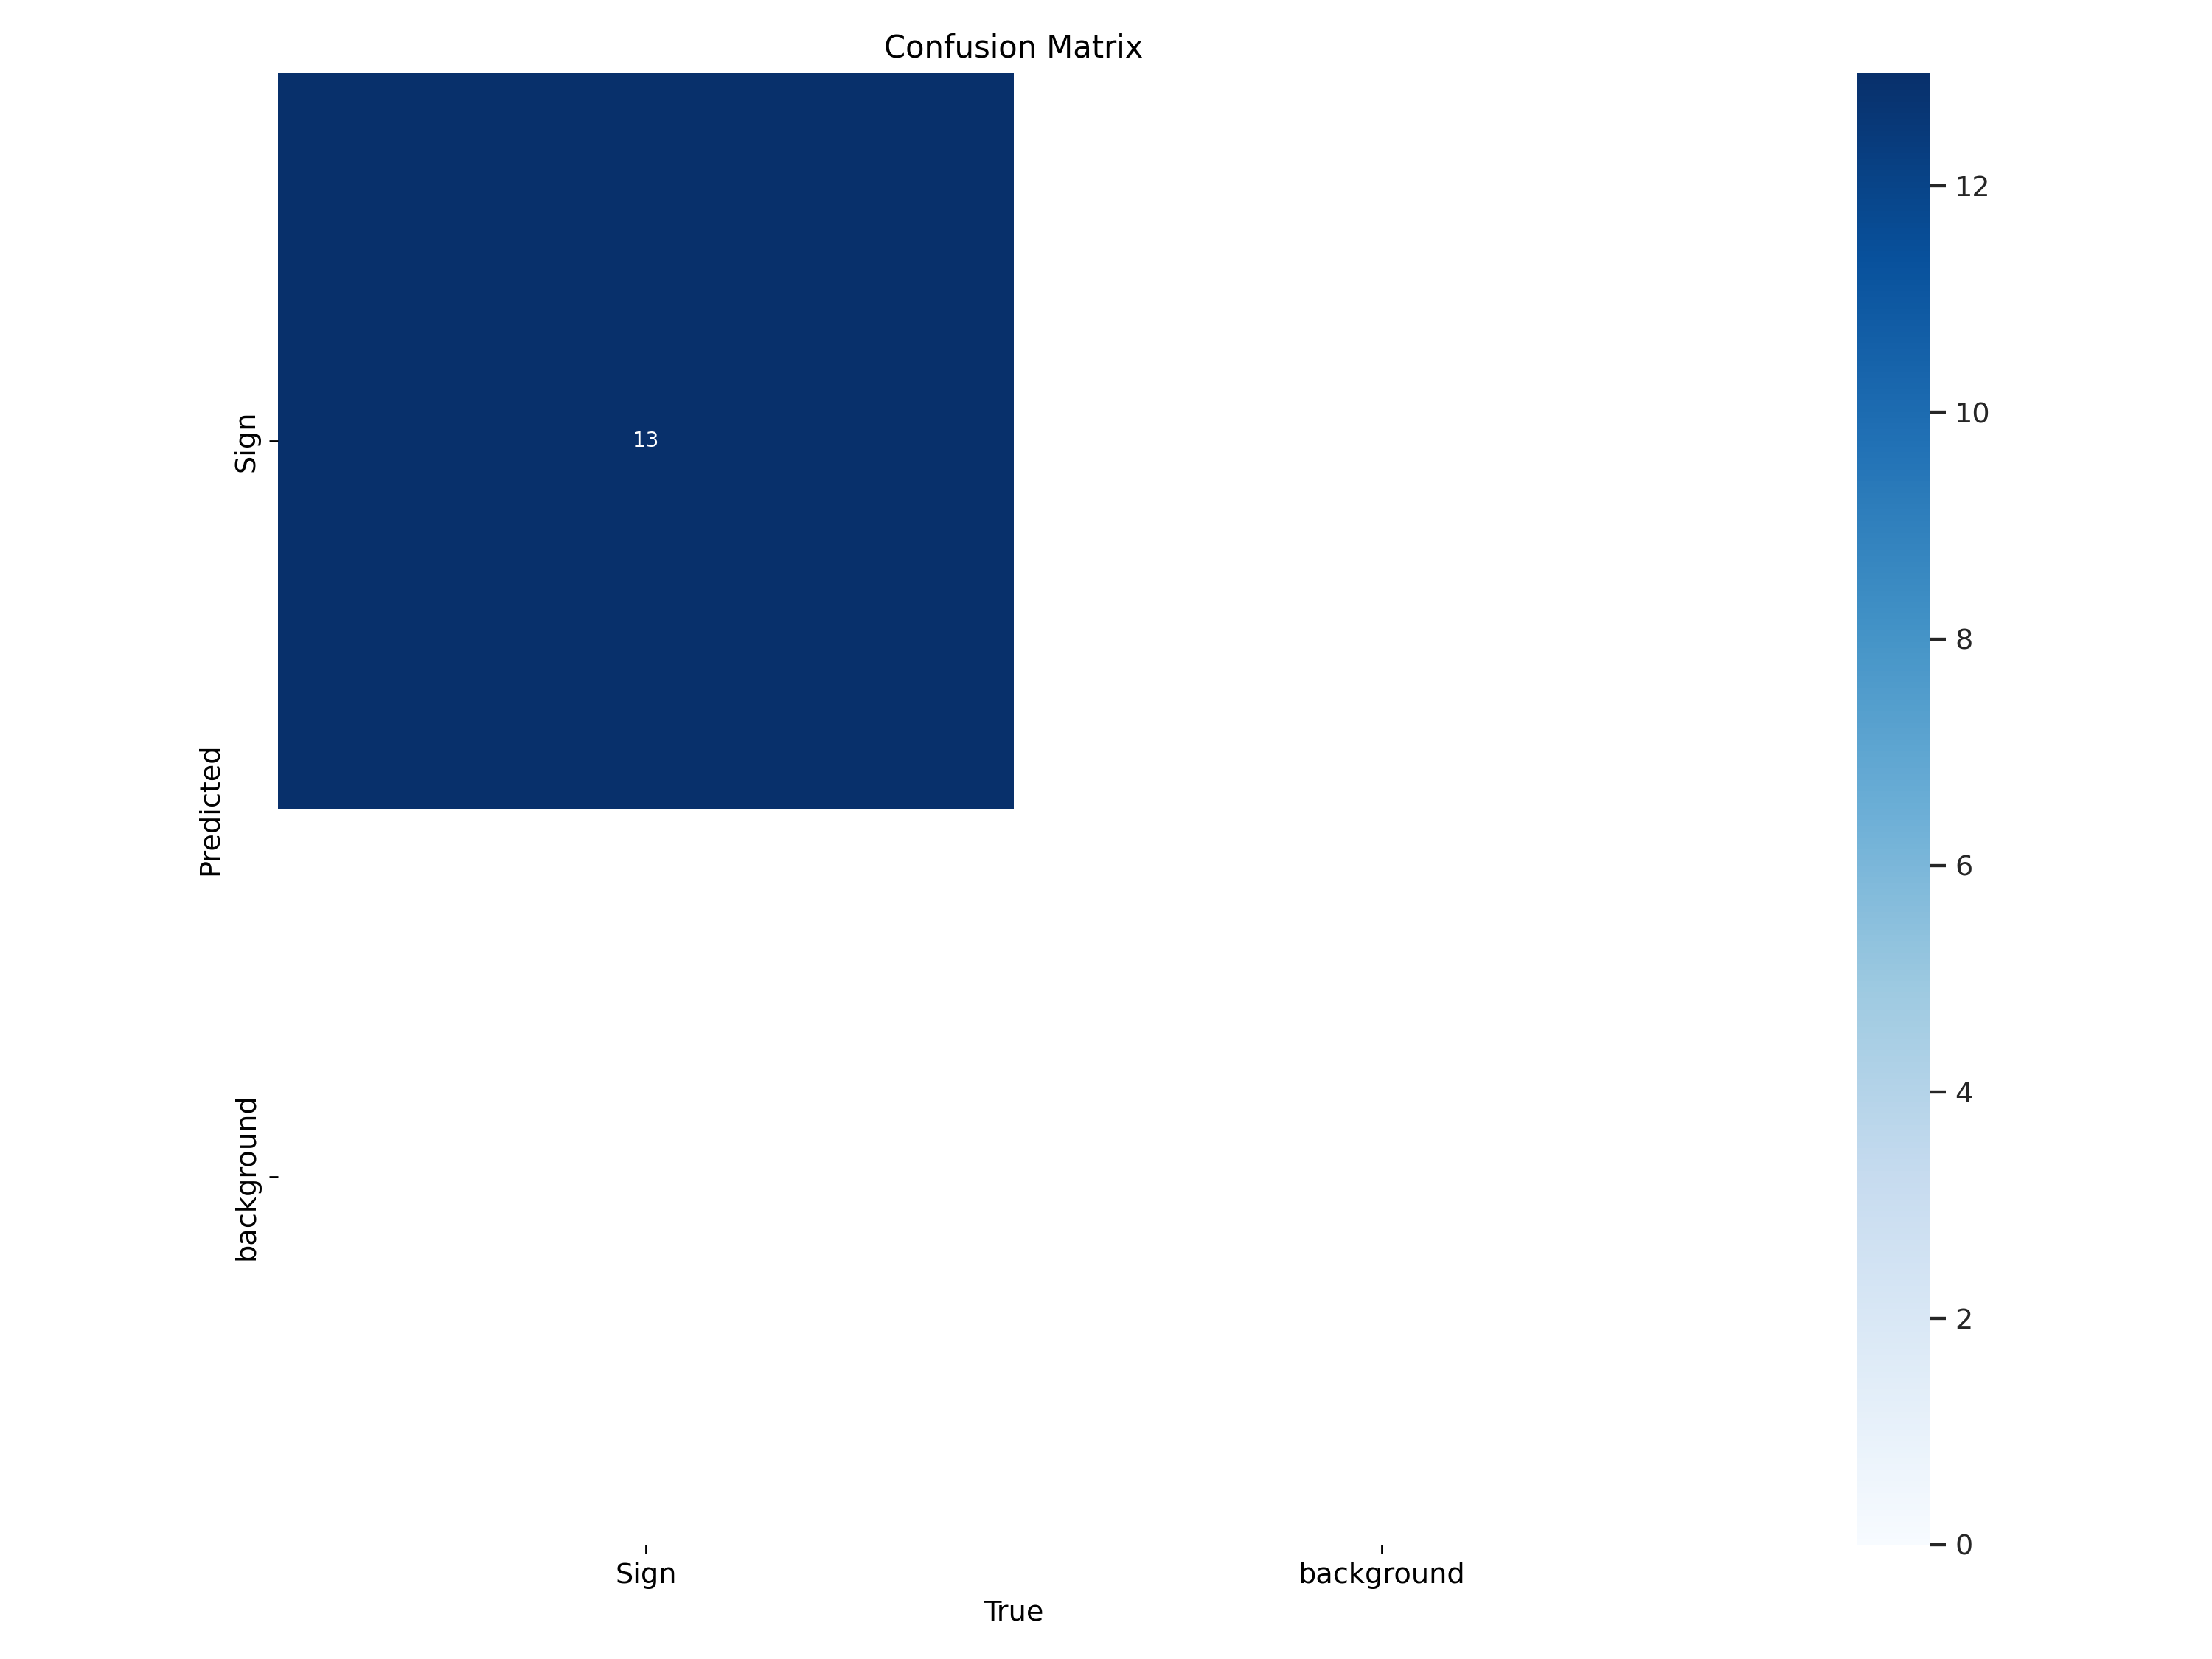

In [19]:
IPyImage(filename=f'{HOME}/runs/detect/val/confusion_matrix.png', width=600)

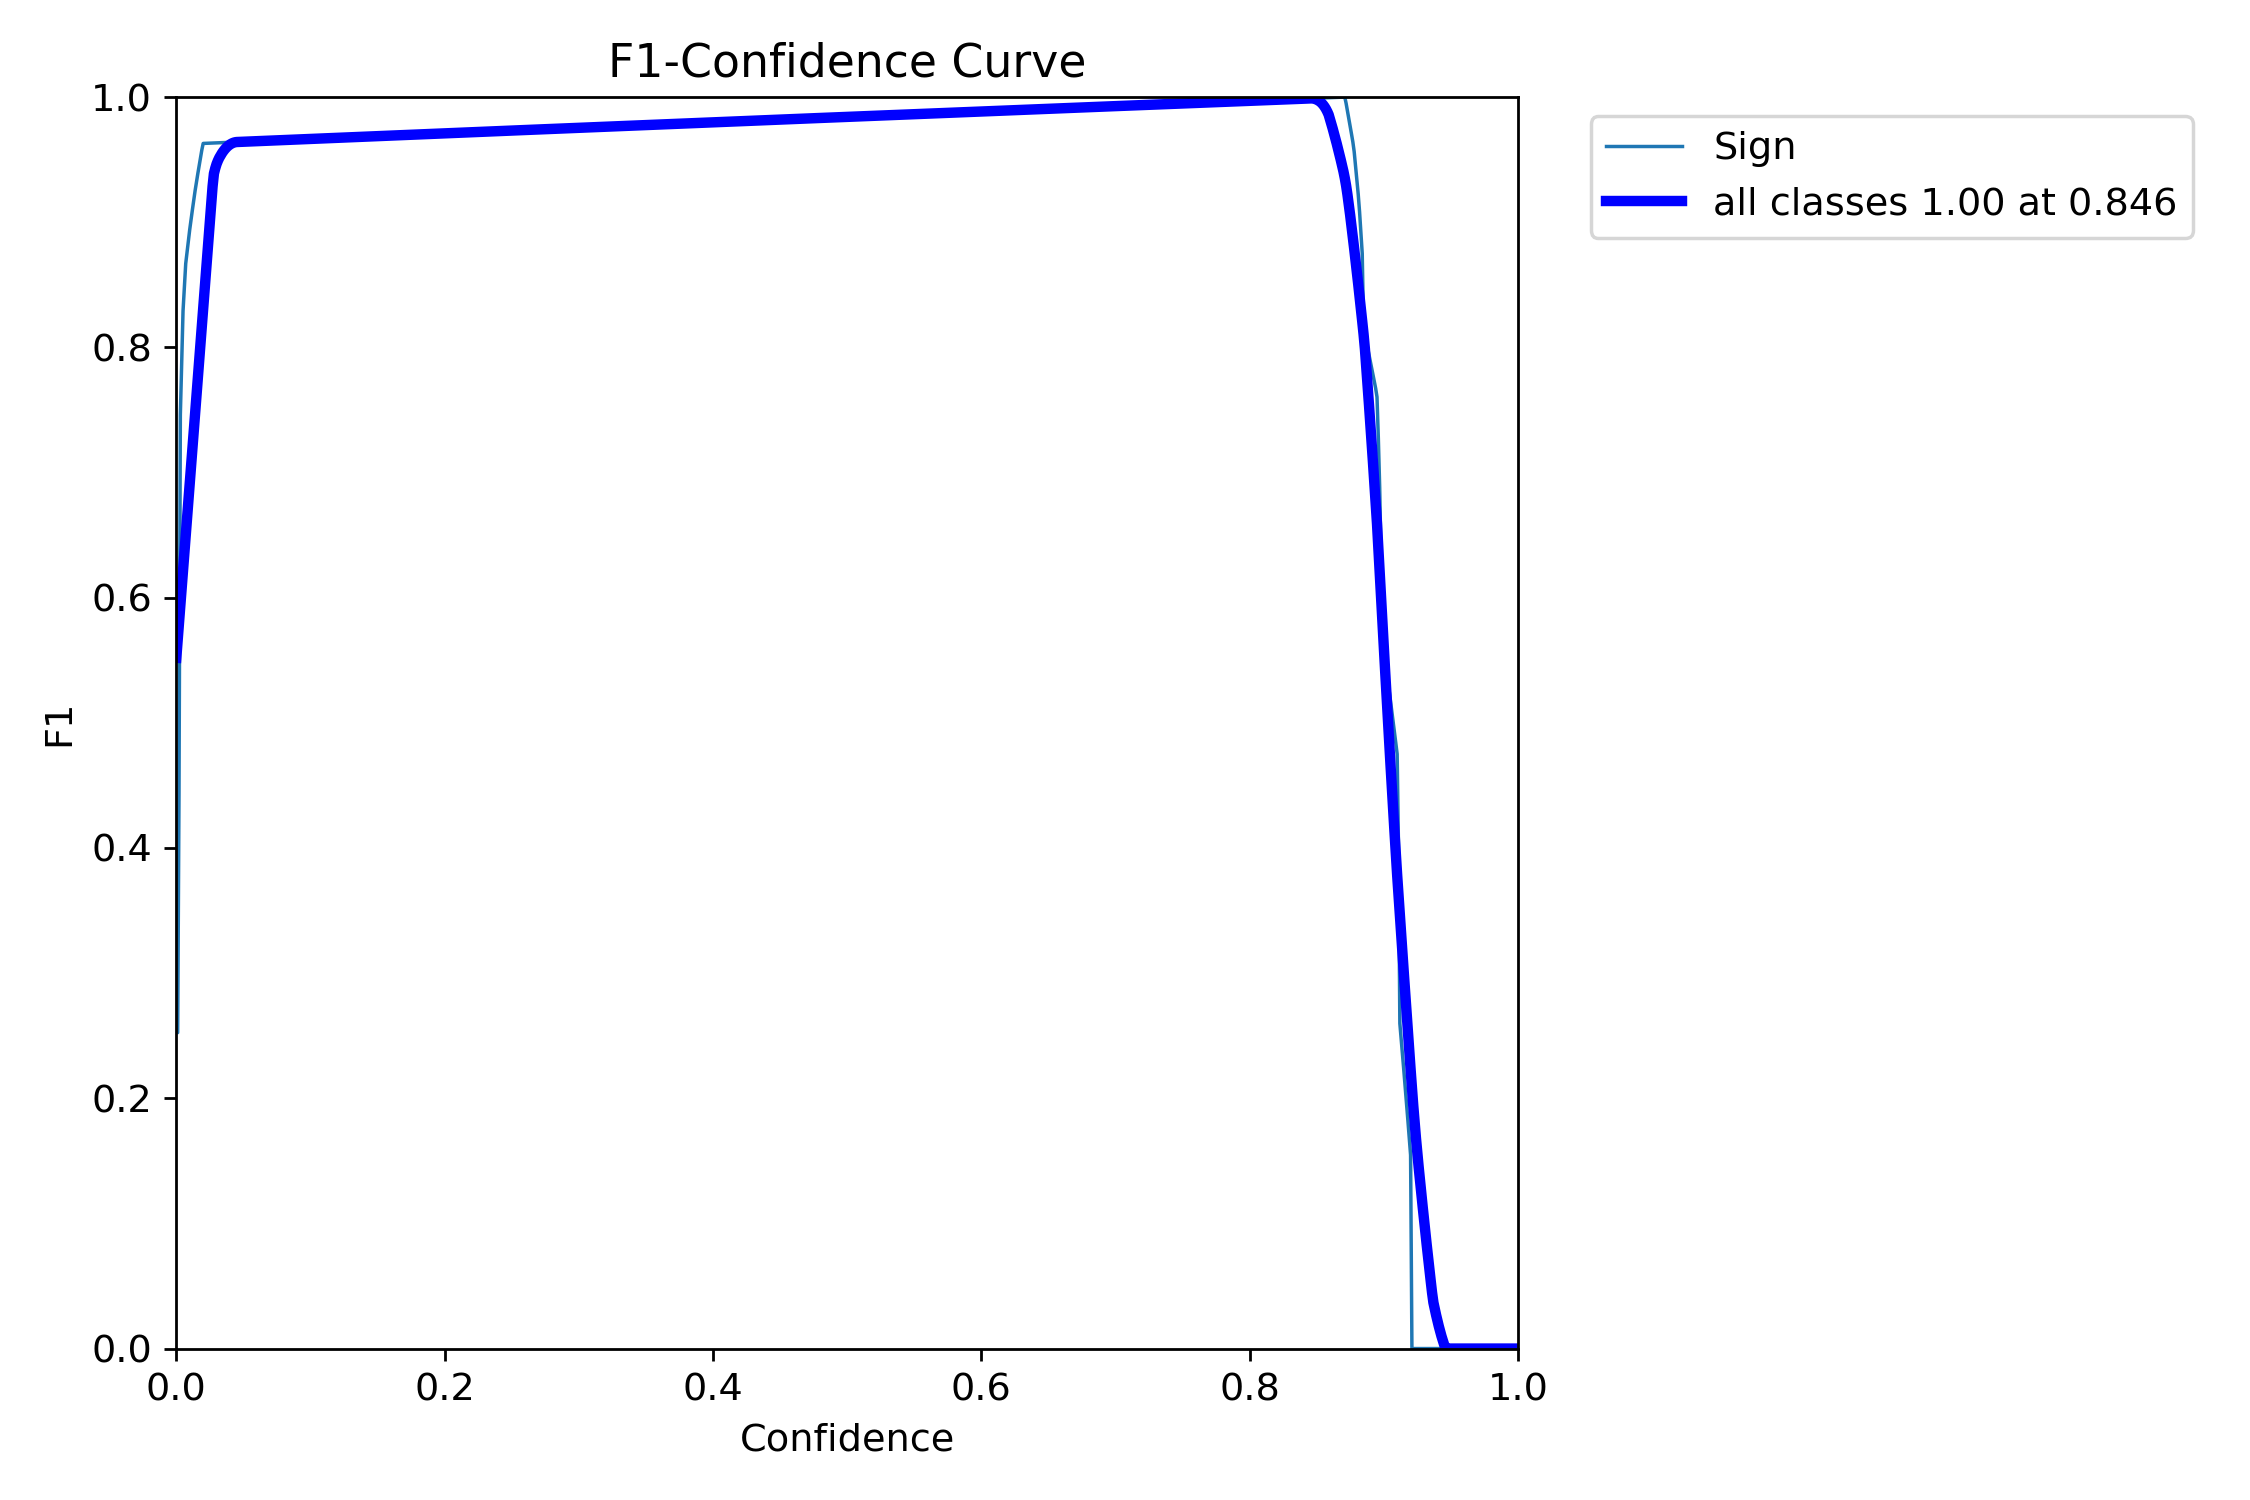

In [20]:
IPyImage(filename=f'{HOME}/runs/detect/val/F1_curve.png', width=600)

## Inference with custom model

Inference on the training data

In [21]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/train/images save=True

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs

image 1/74 /content/datasets/StopSignFinder-2/train/images/cee5bc7f-68fa-4d17-856a-e9f710f27d32-sign_png.rf.7d97b257eebd69d780135a9ce25b4fe9.jpg: 512x512 1 Sign, 13.9ms
image 2/74 /content/datasets/StopSignFinder-2/train/images/cef3aba6-ae46-41f5-8162-96ec6e1bd007-nosign_png.rf.a3c42fefd254471495a5bf9718210950.jpg: 512x512 (no detections), 11.2ms
image 3/74 /content/datasets/StopSignFinder-2/train/images/cf0e61b1-715d-46a9-b713-a0b1a190e00d-nosign_png.rf.dcdb033f501bf3c91b5d8d24b5e987bf.jpg: 512x512 (no detections), 11.1ms
image 4/74 /content/datasets/StopSignFinder-2/train/images/cf173562-b37a-4df5-8d9c-5ed7dc359849-sign_png.rf.85a1ab00bd18d3900d1223efd7d0bbeb.jpg: 512x512 1 Sign, 11.1ms
image 5/74 /content/datasets/StopSignFinder-2/train/images/cf8d6c4f-0522-4319-befc-4f746be1c122-nosign_png.rf.ac58d0963dbfa5f08853e55f5

Predicition on the test data

In [22]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs

image 1/100 /content/datasets/StopSignFinder-2/test/images/e0762af3-aeee-4e8a-8c03-7b10873541d4-nosign_png.rf.d3a8f4029335b423d4b3593917b8c8cd.jpg: 512x512 1 Sign, 14.3ms
image 2/100 /content/datasets/StopSignFinder-2/test/images/e1623e7b-e36d-466a-a122-e1a558b7f5b9-sign_png.rf.08f06e009f61a6f3aaee7cbb9f94eaca.jpg: 512x512 1 Sign, 11.2ms
image 3/100 /content/datasets/StopSignFinder-2/test/images/e1629188-79ac-4808-924f-ecb6359617cd-sign_png.rf.5d6768facc8354e015cb263b4a705ff6.jpg: 512x512 1 Sign, 11.1ms
image 4/100 /content/datasets/StopSignFinder-2/test/images/e5760387-fc63-4b2d-9d7e-d70e632ac375-sign_png.rf.91d153863e86440eb6e3ad2fd98993aa.jpg: 512x512 1 Sign, 11.0ms
image 5/100 /content/datasets/StopSignFinder-2/test/images/e592c7e7-4c4e-4cb1-9ea1-1158e2e2e3fc-nosign_png.rf.7d2e450f51d2b91cacfe451f1fdda6c1.jpg: 512x512

Automated way to compare the image file name (-sign or -nosign) and see if the detections match

In [25]:
result = !yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images/e0762af3-aeee-4e8a-8c03-7b10873541d4-nosign_png.rf.d3a8f4029335b423d4b3593917b8c8cd.jpg

In [30]:
import glob

images_path = os.path.join(dataset.location, "test/images")

# Loop through all .jpg files in the specified directory
for image_file in glob.glob(os.path.join(images_path, "*.jpg")):
    #print(os.path.exists(image_file))
    result = !yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source=image_file

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


# Individual Results

View the prediction results on images

In [ ]:
import glob

latest_folder = max(glob.glob('/content/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:20]:
    display(IPyImage(filename=img, width=600))
    print("\n")

## Deploy model on Roboflow

Optional area to upload data back to Roboflow

In [ ]:
project.version(dataset.version).deploy(model_type="yolov11", model_path=f"{HOME}/runs/detect/train/")

In [ ]:
!pip install inference

In [ ]:
import os, random, cv2
import supervision as sv
import IPython
import inference

model_id = project.id.split("/")[1] + "/" + dataset.version
model = inference.get_model(model_id, userdata.get(''))

# Location of test set images
test_set_loc = dataset.location + "/test/images/"
test_images = os.listdir(test_set_loc)

# Run inference on 4 random test images, or fewer if fewer images are available
for img_name in random.sample(test_images, min(4, len(test_images))):
    print("Running inference on " + img_name)

    # Load image
    image = cv2.imread(os.path.join(test_set_loc, img_name))

    # Perform inference
    results = model.infer(image, confidence=0.4, overlap=30)[0]
    detections = sv.Detections.from_inference(results)

    # Annotate boxes and labels
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    annotated_image = box_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Display annotated image
    _, ret = cv2.imencode('.jpg', annotated_image)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)


# Download to Local PC (model files)

Download data to PC by zipping files for datasets and runs (runs contains the best.pt file found in runs/detect/train/weights/)

In [ ]:
!zip -r datasets.zip datasets/

In [ ]:
!zip -r runs.zip runs/